In [3]:
spark

In [4]:
import json
import numpy as np
import time
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
from matplotlib import font_manager, rc

In [9]:
def preprocessing(data):
    data = data.filter((data.inflow_channel == "i") & (data.tabcode == "tot"))
    return data

In [10]:
query_data = spark.read.json('/Log/Type=Search/SubType1=Dialog/SubType2=Hour/Device=PC/Kind=Query/Year=2019/Month=07/Day=14/Hour=20')
click_data = spark.read.json('/Log/Type=Search/SubType1=Dialog/SubType2=Hour/Device=PC/Kind=Click/Year=2019/Month=07/Day=14/Hour=20')

In [11]:
query_data = preprocessing(query_data)
click_data = preprocessing(click_data)

In [12]:
ser_query = query_data.filter(query_data.display.SER.isNotNull()).select("display.SER.code")

In [13]:
ser_click = click_data.filter(click_data.collection.isNotNull()).select('collection.code')

In [14]:
def flatten(list):
    li = []
    for meta in list:
        if type(meta) == type([]):
            li.extend(flatten(meta))
        else:
            li.append(meta)
    return li

In [28]:
code_list = []
ser = ser_query.collect()
for meta in ser:
    code_list.append(meta[0])
code_list = flatten(code_list)

In [29]:
df = sc.parallelize(code_list).map(lambda x: (x,)).toDF(["code"])

In [30]:
code_count = df.groupBy("code").count().sort("count",ascending=False).withColumnRenamed('count','code_count')
code_count_list = code_count.collect()

In [42]:
code_count.take(10)

[Row(code=u'BR1', code_count=419314),
 Row(code=u'CCB', code_count=399221),
 Row(code=u'CLO', code_count=365673),
 Row(code=u'NNS', code_count=340990),
 Row(code=u'WSA', code_count=337882),
 Row(code=u'VO2', code_count=304551),
 Row(code=u'NKS', code_count=286349),
 Row(code=u'IIM', code_count=280929),
 Row(code=u'IVR', code_count=257677),
 Row(code=u'1DV', code_count=192949)]

In [ ]:
ser_query.take(1)

In [31]:
code_v = []
for meta in code_count_list:
    code_v.append(meta[1])

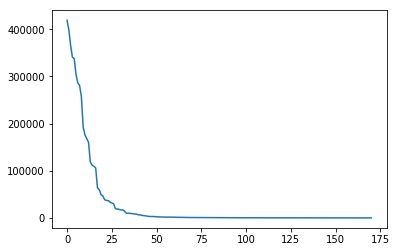

In [32]:
plt.plot(code_v)
plt.show()

In [33]:
click_count = ser_click.groupBy("code").count().sort("count",ascending=False).withColumnRenamed('count','click_count')

In [34]:
code_count.printSchema()
click_count.printSchema()

root
 |-- code: string (nullable = true)
 |-- code_count: long (nullable = false)

root
 |-- code: string (nullable = true)
 |-- click_count: long (nullable = false)



In [35]:
ctr = code_count.join(click_count, code_count.code == click_count.code, 'inner').drop(click_count.code)

In [36]:
ctr.printSchema()

root
 |-- code: string (nullable = true)
 |-- code_count: long (nullable = false)
 |-- click_count: long (nullable = false)



In [37]:
ctr = ctr.withColumn('ctr', ctr.click_count / ctr.code_count).sort('ctr',ascending=False)

In [38]:
ctr_list = ctr.select("code","ctr","code_count","click_count").collect()

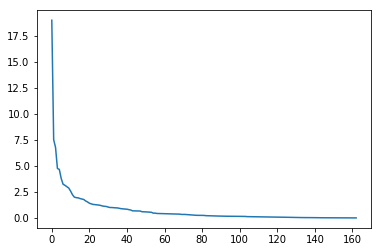

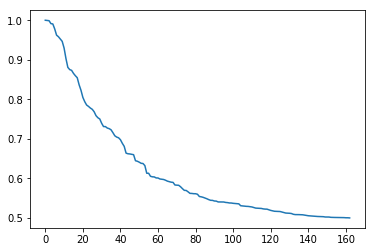

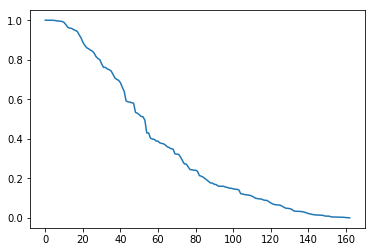

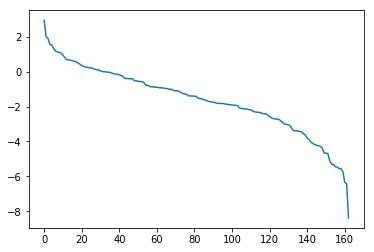

In [39]:
ctr_v = []
ctr_sig = []
ctr_tanh = []
for ctr in ctr_list:
    ctr_v.append(ctr[1])
    ctr_sig.append(1/(1+np.exp(-ctr[1])))
    ctr_tanh.append((np.exp(ctr[1])-np.exp(-ctr[1]))/(np.exp(ctr[1])+np.exp(-ctr[1])))
    
plt.plot(ctr_v)
plt.show()
plt.plot(ctr_sig)
plt.show()
plt.plot(ctr_tanh)
plt.show()
plt.plot(np.log(ctr_v))
plt.show()

In [40]:
for ctr in ctr_list:
    print (ctr)

Row(code=u'CC9', ctr=19.0, code_count=1, click_count=19)
Row(code=u'Z7T', ctr=7.519230769230769, code_count=52, click_count=391)
Row(code=u'CC4', ctr=6.769230769230769, code_count=13, click_count=88)
Row(code=u'CC5', ctr=4.75, code_count=4, click_count=19)
Row(code=u'FMU', ctr=4.666666666666667, code_count=3, click_count=14)
Row(code=u'CC3', ctr=3.8, code_count=10, click_count=38)
Row(code=u'UNS', ctr=3.24031007751938, code_count=516, click_count=1672)
Row(code=u'Z1T', ctr=3.1339285714285716, code_count=224, click_count=702)
Row(code=u'CC6', ctr=3.0, code_count=2, click_count=6)
Row(code=u'CC2', ctr=2.875, code_count=16, click_count=46)
Row(code=u'Z8T', ctr=2.582227081055755, code_count=6403, click_count=16534)
Row(code=u'CC1', ctr=2.232142857142857, code_count=112, click_count=250)
Row(code=u'BK1', ctr=2.0, code_count=13, click_count=26)
Row(code=u'MOR', ctr=1.9472222222222222, code_count=360, click_count=701)
Row(code=u'TR2', ctr=1.930301240401654, code_count=1693, click_count=3268)
